# Exploring StackOverflow!

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from collections import Counter

## Populating the Graphs

Each graph is build independantly from the provided `.txt` files of temporal network of interactions. \
Users are represented as nodes and answers\comments as edges.

The design choices of the following method are:
- Using directed graphs. 
- *Simple* graphs, there are no loops in the graphs. Users who answer to themselves are discarded cases.
- Only one attributes is assigned to the edges: weight. The weights are:
    - `1` for answers to questions
    - `.75` for comments on questions
    - `.5` for comments to answers
- The graphs are build given a time input to avoid such attribute for the sake of simplicity and robustess.

In [4]:
def from_time_int_to_dates(time_interval):
    # Convert the time interval in start and end dates 
    time_interval = tuple(map(datetime.fromisoformat, time_interval)) # converting time interval into datetime format
    time_interval = tuple(map(datetime.timestamp, time_interval)) # converting time interval into POSIX timestamp 
    start_d = int(time_interval[0]) #converting to string to compare with the txt
    end_d = int(time_interval[1])
    return start_d, end_d

In [6]:
def get_graph(time_interval, file = 3):
    
    # Initialize the graph
    G = nx.DiGraph()
    
    # Create mapping of files and mapping of weights
    map_files = {1: "sx-stackoverflow-a2q.txt", 2:"sx-stackoverflow-c2q.txt", 3:"sx-stackoverflow-c2a.txt"}
    map_weights = {1: 1.0, 2: .75, 3: .5}
    
    # Get the start and end dates 
    start, end = from_time_int_to_dates(time_interval)
    
    # Select the file chosen, open it and read the lines
    with open(map_files[file], "r", encoding="UTF-8") as f:
        for line in f.readlines():
            
            # Parse the line
            elems = line.split(' ')
            date = int(elems[2])
            if date <= end:
                # Add to the graph if it is in the time interval
                if date >= start:
                    # If the edge already exists --> increment the weight, else simply add the new edge
                    if (elems[0], elems[1]) in G.edges():
                        G[elems[0]][elems[1]]['weight'] += float(map_weights[file])
                    else:
                        G.add_edge(elems[0], elems[1], weight = float(map_weights[file]))
            else:
                break
                    
    return G

### Merging the graphs

This function will merge two graphs that were obtained by the function **get_graph()** with the same time interval. 

In [7]:
def merged_graph(graph_1, graph_2):
    
    # Iterate over the edges from the second graph
    for edge_2 in graph_2.edges(data = True):
        # If the edge of graph 2 is also in graph 1, only sum weights
        if (edge_2[0],edge_2[1]) in graph_1.edges():
            graph_1[edge_2[0]][edge_2[1]]['weight'] += float(edge_2[2]['weight'])
        # Else add the edge of graph 2 also in graph 1
        else:
            graph_1.add_edge(edge_2[0], edge_2[1], weight = float(edge_2[2]['weight']))
            
    return graph_1

In [8]:
def build_merged_graph(TimeInterval):
    # generating graph
    graph1 = get_graph(time_interval=TimeInterval, file=1)
    graph2 = get_graph(time_interval=TimeInterval, file=2)
    graph3 = get_graph(time_interval=TimeInterval, file=3)
    merged = merged_graph(graph1, graph2)
    merged = merged_graph(merged, graph3)
    d_merge = nx.to_dict_of_dicts(merged)
    
    return merged, d_merge

In [6]:
merged, d_merge = build_merged_graph(("2008-11-01","2008-11-02"))

### Functionality 1 - Get the overall features of the graph

Graph density/sprcity is computed as defined in *"Introduction to Algorithms" by Cormern, Leiserson, Rivest, and Stein*: \
A graph $G = (E, V)$, with $E$ denoting the edges and $V$ denoting the vertices,  is sparse if $|E| << |V|^2$ and dense if $|E|$ is close to $|V|$. \
And so if $|E|$ differs an order of magnitude from $|V|$ the graph is considered sparse, otherwise it is dense.
The density degree expression is:

\begin{equation}
\frac{|V|}{|E|(|E| - 1)} \approx \frac{|V|}{|E|^2}
\end{equation}

In [7]:
# Input: a graph as a dict of dicts
# Output: a boolean True/False

def directed(dict_graph):
    direct = False
    # Iterating through the dictionary items
    for node, neighbours in dict_graph.items():
        # For each list of adjacency of node
        for neighbour in list(neighbours.keys()):
            # If the node is not present in the adj list of his neighbours --> break
            if node not in list(dict_graph[neighbour].keys()):
                direct = True
                break
    return direct

In [8]:
# Input: a graph as a dict of dicts
# Output: number of nodes in the graph

def n_users(dict_graph):
    # Return number of keys
    return len(dict_graph)

In [9]:
# Input: a graph as a dict of dicts
# Output: number of edges in the graph

# For this implementation we considered the "out-degree" = number of edges coming out from the node 
def n_interactions(dict_graph):
    # Sum the length of lists of edges
    n_int = 0
    for neighbour in dict_graph.values():
        n_int += len(list(neighbour.keys()))
    return n_int

In [10]:
# Input: a graph as a dict of dicts
# Output: average number of links for nodes

def average_n_links(dict_graph):
    return n_interactions(dict_graph) / n_users(dict_graph)

In [20]:
def F1_OverallFeatures(dict_graph):
    """
    Input: One of the 3 graphs in dictionary format

    Output:
      Whether the graph is directed or not
      Number of users
      Number of answers/comments
      Average number of links per user
      Density degree of the graph
      Whether the graph is sparse or dense
    """
    
    # quering if the graph is directed
    Directed = directed(dict_graph)
    
    # using a variable to print the output
    if Directed: 
        IsDirectedPrint = 'directed'
    else:
        IsDirectedPrint = 'undirected'
        
    # computing the number of users
    NofUsers = n_users(dict_graph) 
    
    # computing the number of interactions
    NofInteractions = n_interactions(dict_graph)
    
    # computing the avarege number of links per user
    AvgUserLinks = average_n_links(dict_graph)
    
    # computing density degree
    DensityDegree = NofInteractions / NofUsers**2
    
    # evaluating sparsity/density
    if NofUsers / NofInteractions**2 < 10:
        SparseDense = 'sparse'
    else:
        SparseDense = 'dense'
        
    # print the results
    print(f"The input graph is -> {IsDirectedPrint}")
    print(f"Number of users -> {NofUsers}")
    print(f"Number of answers/comments -> {NofInteractions}")
    print(f"Average number of links per user -> {AvgUserLinks:.2}")
    print(f"Density degree -> {DensityDegree: .2}")
    print(f"The graph is -> {SparseDense}")

In [21]:
F1_OverallFeatures(d_merge)

The input graph is -> directed
Number of users -> 1043
Number of answers/comments -> 1538
Average number of links per user -> 1.5
Density degree ->  0.0014
The graph is -> sparse


### Functionality 2 - Find the best users!

#### Degree centrality
As defined in *Introduction to Graph Concepts for Data Science of Aris Anagnostopoulos*, the normalized degree centrality of node $v$ is:

\begin{equation}
\frac{d_v}{|V|-1} \approx \frac{d_v}{|V|}
\end{equation}

with $d_v$ the degree of the node $v$, i.e. the number of edges incident to the node.

In [9]:
# Calculate the degree as "out-degree"
def degree(dict_graph, node):
    return len(list(dict_graph[node].values()))

In [12]:
# Calculate the degree as "in-degree"
def in_degree(dict_graph, node):
    out = 0
    for u in list(dict_graph.keys()):
        if u != node and (node in list(dict_graph[u].keys())):
            out += 1
    return out

In [13]:
# Apply the definition
def degree_centrality(dict_graph, node):
    out = degree(dict_graph, node) / n_interactions(dict_graph)
    print(f"{out:.2}")

#### Test the degree centrality

In [19]:
degree_centrality(d_merge, "30155")

0.0013


In [20]:
degree_centrality(d_merge, "4120")

0.002


#### Closeness centrality
As defined in *Introduction to Graph Concepts for Data Science of Aris Anagnostopoulos*, the normalized closeness centrality of node $v$ is:


\begin{equation}
\frac{|V|-1}{\sum_{u \epsilon V} d(v,u)} \approx \frac{|V|}{\sum_{u \epsilon V} d(v,u)}
\end{equation}

with $d(v,u)$ the distance between nodes $v$ and $u$, that is the length of a shortest path between $v$ and $u$.\
As a design choice $d(v,u)$ is taken as the inverse of the weight of the edge of $(v,u)$, this leads to an inverse relationship between interaction and distances: the more a user posts, the closer he gets to the comunity.  

In [10]:
def get_outgoing_edges(dict_graph, node):
    return list(dict_graph[node].keys())

In [11]:
# Input: a graph as a dict of dicts, the start node
# Output: two dictionaries: the first memorize the nodes involved in the shortest paths, the second is the shortest path in distance terms.
# Pseudocode from: https://en.wikipedia.org/wiki/Dijkstra's_algorithm#Pseudocode

def shortest_path_Dijkstra(dict_graph, node):
    
    # Initialize two dictionaries to track visited nodes and weights
    nodes_dist = dict.fromkeys(dict_graph.keys(), float('inf'))
    
    # Initialize another dictionary that track the nodes in the shortest path
    previous_nodes = dict.fromkeys(dict_graph.keys())
    
    # Create a list of the unvisited nodes 
    unvisited = list(dict_graph.keys())
    
    # First update on the selected node
    nodes_dist[node] = 0
    
    # Start iterating until each node is visited
    while(unvisited):
        
        # Select the current min_node with a for-loop
        min_node = None
        for n in unvisited:
            if min_node == None:
                min_node = n
            elif nodes_dist[n] < nodes_dist[min_node]:
                min_node = n
            
        # Update distances of the current min_node's neighbors
        neighbors = get_outgoing_edges(dict_graph, min_node)
        for neighbor in neighbors:
            # Calculate the possible update to the shortest path and check if it is < then the actual distance
            possible_update = nodes_dist[min_node] + dict_graph[min_node][neighbor]['weight']
            if possible_update < nodes_dist[neighbor]:
                nodes_dist[neighbor] = possible_update
                # We also update the best path to the current node
                previous_nodes[neighbor] = min_node
        
        # Remove the current min_node from the unvisited list
        unvisited.remove(min_node)
    
    return previous_nodes, nodes_dist

In [16]:
def nodes_shortest_path(previous_nodes, start_node, target_node):
    path = []
    node = target_node
    
    while node != start_node:
        if node == None:
            return []
        path.append(node)
        node = previous_nodes[node]
        
    # Add the start node manually
    path.append(start_node)
    
    return list(reversed(path))

In [17]:
prev_nodes , nodes_distances = shortest_path_Dijkstra(d_merge, '18313')

In [18]:
# peso totale con cui vado da '18313' a "19964"
min_dis_dijk = nodes_distances["19964"]

In [22]:
min_dis_dijk

inf

In [19]:
# path completo dall'inizio alla fine
nodes_shortest_path(prev_nodes,'18313', "19964")

[]

In [27]:
def norm_closeness_centrality(dict_graph, v):
    
    # Create a list with all the nodes except the one considered
    nodes = list(dict_graph.keys())
    nodes.remove(v)
    
    # Iterate and calculate the denominator adding all the distances calculated with Dijkstra
    denom = 0
    _, dists = shortest_path_Dijkstra(dict_graph, v)
    
    for u in nodes:
        denom += dists[u]
        
    # Return the result
    return (n_users(dict_graph)) / denom

#### Test the closeness centrality

In [28]:
norm_closeness_centrality(d_merge, "18313")

0.0

In [29]:
norm_closeness_centrality(d_merge, "19964")

0.0

#### Page rank

The page rank algorithm will be implemented with Random Surfer Model in which we will use a value $\alpha$ to adjust all the points in the matrix of edges(a matrix where there are ones if the edge exists and zeros otherwise).

The matrix of edges could be full of zeros, so in order to save space in memory, we will not store it. We simply modify a dictionary with as keys the nodes and as values the corrispondant page rank score:

The update equation looks like this:

\begin{equation}
PageRank(v) = \frac{\alpha}{n} + (1-\alpha) * \sum_{e_{u,v} \in E}^{} \frac{PageRank(u)}{OutDegree(u)}
\end{equation}

where $v$ is the target node, $n$ is the number of edges in the graph and $e_{u,v} \in E$ means that exists an edge between $u$ and $v$.

In [23]:
# This function will return a list of all parents of a node

def get_parents(dict_graph, node):
    out = []
    for u in list(dict_graph.keys()):
        # Check for each node in which children list appear and append it to the final list
        if u != node and (node in list(dict_graph[u].keys())):
            out.append(u)
    return out

In [24]:
# This function will return a list of children of a node

def get_children(dict_graph, node):
    return list(dict_graph[node].values())

In [25]:
# This function will execute the update to the pagerank dictionary

def update_pagerank(dict_graph, node, alpha, pagerank):
    
    # Take the parents of the node
    parents = get_parents(dict_graph, node)
    
    # Calculate the sum term of the formula
    pagerank_sum = sum((pagerank[node] / len(get_children(dict_graph, node))) for node in parents)
    
    # Calculate the random alpha-dependent term
    random_walk = alpha / n_users(dict_graph)
    
    # Update the pagerank score of the node
    pagerank[node] = random_walk + (1 - alpha) * pagerank_sum

In [26]:
# Pagerank algorithm with standard optimal value for damping factor alpha = 0,85

def page_rank(dict_graph, alpha=0.85, n_iterations=5):
    # Initialize the pagerank dictionary that will be updated by the pagerank algrithm
    pagerank = dict.fromkeys(dict_graph.keys(), 0)
    
    # All nodes of the graph in a list
    nodes = list(dict_graph.keys())
    
    # Start iterating the algorithm
    for i in range(n_iterations):
        
        # For each node update the pagerank dictionary --> execute algorithm
        for node in tqdm(nodes):
            update_pagerank(dict_graph, node, alpha, pagerank)
            
        if i == 0:
            # In the first iteration we save all dict values for next iterations comparisons
            prev = list(pagerank.values())
        else:
            # Tracking how many values converge
            count = 0
            for pr, actual in zip(prev, list(pagerank.values())):
                if pr == actual:
                    count += 1
            print("Convergence for --> " + str(count) + " values.")
            # Update the previous values list
            prev = list(pagerank.values())
            
    # Return the pagerank dictionary obtained running the algorithm "n_iterations" times
    return pagerank

#### Test the page rank

In [34]:
result = page_rank(d_merge)

100%|██████████| 1043/1043 [00:00<00:00, 4714.65it/s]


Convergence for --> 595 values.


100%|██████████| 1043/1043 [00:00<00:00, 4714.48it/s]


Convergence for --> 676 values.


100%|██████████| 1043/1043 [00:00<00:00, 4778.53it/s]


Convergence for --> 695 values.


100%|██████████| 1043/1043 [00:00<00:00, 5012.80it/s]

Convergence for --> 697 values.


#### Betweeness

As defined in *Introduction to Graph Concepts for Data Science of Aris Anagnostopoulos*, the Betweeness centrality of node $v$ is:

\begin{equation}
\frac{2}{|V|^2 - 3|V| + 2} * \sum_{u, w \epsilon V \backslash \{v\}} \frac{g_{u w}^v}{g_{uw}}
\end{equation}


with $g_{uw}$ the shortest path that connects nodes $u$ and $w$ and $g_{u w}^v$ the set of those shortest paths between u and w that contain node $v$.

In [12]:
# Implementing a class to manage a queue

class MyQueue:

    def __init__(self):
        self.holder = []

    def enqueue(self,val):
        self.holder.append(val)

    def dequeue(self):
        val = None
        try:
            val = self.holder[0]
            if len(self.holder) == 1:
                self.holder = []
            else:
                self.holder = self.holder[1:]   
        except:
            pass

        return val  

    def IsEmpty(self):
        result = False
        if len(self.holder) == 0:
            result = True
        return result

In [28]:
# This function is a modified BFS version that computes all the possible shortest path between "start" node and 
# "end" node, taking into account the dijkstra distance computed

def BFS(graph, start, end, min_dijk):
    
    # Initialize the queue, final list of paths and weigths variable
    q = MyQueue()
    final = []
    weights = 0
    
    # Initialize the path
    temp_path = [start]
    
    q.enqueue(temp_path)
    
    # Iterating until the queue is empty 
    while q.IsEmpty() == False:
        tmp_path = q.dequeue()
        last_node = tmp_path[len(tmp_path)-1]
    
        # If the last node is our end node --> check the sum weights and if it is equal to minimum Dijkstra distance --> this is a correct minimum path 
        if last_node == end:
            for i in range(len(tmp_path)-1):
                weights += graph[tmp_path[i]][tmp_path[i+1]]["weight"]
            if weights == min_dijk:
                final.append(tmp_path)
        # Enqueue new path to analyze in the queue
        for link_node in graph[last_node]:
            if link_node not in tmp_path:
                new_path = tmp_path + [link_node]
                q.enqueue(new_path)
                
    return final

In [75]:
def betweeness(dict_graph, v):
    
    # Create a list with all the nodes except the one considered
    nodes = list(dict_graph.keys())
    nodes.remove(v)
    
    # Create the two terms of the formula
    fraction = 0
    const = (2 / ((n_users(dict_graph))**2 - 3*(n_users(dict_graph)) + 2))
    
    # Iterating the list with a double for-loop
    for u in tqdm(nodes):
        for w in nodes:
            g_u_v_w = 0
            g_u_w = 0
            
            # Take lenght of the shortest path between u and w
            previous_nodes, nodes_dist = shortest_path_Dijkstra(dict_graph, u)
            dist_dijk = nodes_dist[w]
            
            # All the min paths
            all_min_path = BFS(dict_graph, u, w, dist_dijk)
            # Number of paths between u and w
            g_u_w += len(all_min_path)
            # Number of paths that contains v between u and w
            g_u_v_w += len([path for path in all_min_path for node in path if node in path and node == v])
            
            # Compute the sum of the fractions
            if g_u_w != 0:
                fraction += (g_u_v_w / g_u_w)

    return fraction * const

#### Test the betweeness centrality

In [47]:
gX, dX = build_merged_graph(("2008-11-01 00:00","2008-11-02 00:00"))
gY, dY = build_merged_graph(("2008-11-02 00:00","2008-11-03 00:00"))

# user buisness
for node in [*gX.nodes]:
    if degree(gX, node) < 4:
        gX.remove_node(node)

for node in [*gY.nodes]:
    if degree(gY, node) < 4:
        gY.remove_node(node)

sX = {*gX.nodes}

sY = {*gY.nodes}

justY = set.difference(sY, sX)
justX = set.difference(sX, sY)

G = nx.compose(gX, gY)
dG = nx.to_dict_of_dicts(G)

In [49]:
print(G)

DiGraph with 95 nodes and 196 edges


In [78]:
betweeness(dG, '6309')

100%|██████████| 94/94 [00:09<00:00,  9.64it/s]


0.04735758407687028

In [74]:
betweeness(dG, '27826')

100%|██████████| 94/94 [00:09<00:00,  9.56it/s]


0.08167467398764586

In [73]:
betweeness(dG, '12725')

100%|██████████| 94/94 [00:09<00:00,  9.67it/s]


0.045069778082818576

In [71]:
nx.betweenness_centrality(G, normalized=True)['17964']

0.019103180050331733

In [49]:
def F2_BestUser(node, time_interval, metric = 4):
    """
    Input:
    A user/node
    The graph on which to perform the analysis.
    A tuple of two dates in ISO format representing an interval of time, e.g. (2015-12-04, 2016-12-04) 
    An integer corresponding to the following metrics: 
      1 -> Betweeness 
      2 -> PageRank
      3 -> ClosenessCentrality 
      4 -> DegreeCentrality
      
    Output:
    The value of the given metric applied over the complete graph for the given interval of time.
    """
    
    _, dict_graph = build_merged_graph(time_interval)
    
    if metric == 1:
        return betweeness(dict_graph, node)
    elif metric == 2:
        return page_rank(dict_graph)[node]
    elif metric == 3:
        return norm_closeness_centrality(dict_graph, node)
    elif metric == 4:
        return degree_centrality(dict_graph, node)
    else:
        "The metric selected doesn't exist."

In [50]:
F2_BestUser('12379', ("2008-11-01","2008-11-02"), 4)

0.00065


### Functionality 3 - Shortest Ordered Route

In [51]:
def F3_ShortestRoute(TimeInterval, UserSequence, FirstLastUser):
   """
   Input:
   
   TimeInterval -> An interval of time
   UserSequence -> A sequence of users p = [u_2, ..., u_n-1]
   FirstLastUser -> Tuple (u_1, u_n) of initial user u_1 and an end user u_n
   
   Output:
   The shortest walk that goes from user p_j to p_n, and that visits in order the nodes in p
   """
   
   # generating graph
   _, d_merge = build_merged_graph(time_interval)
   
   # initializing the list containing the shortest distances between users
   Walk = []
   
   # computing the actual list of users on which the path is computed
   start_user_idx = UserSequence.index(FirstLastUser[0])
   end_user_idx = UserSequence.index(FirstLastUser[1])
   ActualUserSequence = UserSequence[start_user_idx:end_user_idx]
   
   # cycling though the ActualUserSequence input until the user before the last one
   for user in range(len(ActualUserSequence[:-1])): 
      start_user = ActualUserSequence[user]
      end_user = ActualUserSequence[user + 1]
      previous_nodes, nodes_dist = shortest_path_Dijkstra(d_merge, start_user) # finding the shortest path
      
      distance = nodes_dist[end_user]
      
      # checking if nodes are disconnected
      if distance  == float('inf'): 
         print("Not possible")
         break
      else:
         Walk.append(distance) #appending distance to the walk list

   return(sum(Walk))

In [52]:
F3_ShortestRoute(("2014-01-01","2014-01-03"), ["780824", "576786", '577485'], ("780824", '577485'))

5.25

### Functionality 4

In [13]:
# This function is a modified BFS version that computes all the possible shortest path between "start" node and 
# "end" node

def BFS_F4(graph, start, end):
    
    # Initialize the queue, final list of paths and weigths variable
    q = MyQueue()
    final = []
    weights = 0
    
    # Initialize the path
    temp_path = [start]
    
    q.enqueue(temp_path)
    
    # Iterating until the queue is empty 
    while q.IsEmpty() == False:
        tmp_path = q.dequeue()
        last_node = tmp_path[len(tmp_path)-1]
    
        # If the last node is our end node --> check the sum weights and if it is equal to minimum Dijkstra distance --> this is a correct minimum path 
        if last_node == end:
            final.append(tmp_path)
        # Enqueue new path to analyze in the queue
        for link_node in graph[last_node]:
            if link_node not in tmp_path:
                new_path = tmp_path + [link_node]
                q.enqueue(new_path)
                
    return final

In [14]:
def F4_DisconnectingGraphs(timeInterval_X, timeInterval_Y, *args):
    """
    Input:
    Two different intervals of time (disjoint or not)
    Optionally: two users which are unique to each interval of time, otherwise this two users are randomly selected

    Output:
    The minimum number of links required to disconnect the two users.
    """

    # generating graphs
    gX, dX = build_merged_graph(timeInterval_X)
    gY, dY = build_merged_graph(timeInterval_Y)
    
    # user buisness
    for node in [*gX.nodes]:
        if degree(gX, node) < 4:
            gX.remove_node(node)

    for node in [*gY.nodes]:
        if degree(gY, node) < 4:
            gY.remove_node(node)

    sX = {*gX.nodes}

    sY = {*gY.nodes}

    justY = set.difference(sY, sX)
    justX = set.difference(sX, sY)

    G = nx.compose(gX, gY)
    dG = nx.to_dict_of_dicts(G)
    # searching paths
    try:
        tmp = justX.pop() # temporay varible for storing a random user
        while not dX[tmp].values(): # discarding unconnected user
            tmp = justX.pop()
        userX = tmp
        tmp = justY.pop() # temporay varible for storing a random user
        while not dY[tmp].values(): # discarding unconnected user
            tmp = justY.pop()
        userY = tmp

        _, Distance = shortest_path_Dijkstra(dG, userX)

        while Distance[userY] == float('inf'):
            tmp = justX.pop() # temporay varible for storing a random user
            while not dX[tmp].values(): # discarding unconnected user
                tmp = justX.pop()
            userX = tmp
            tmp = justY.pop() # temporay varible for storing a random user
            while not dY[tmp].values(): # discarding unconnected user
                tmp = justY.pop()
            userY = tmp

            _, Distance = shortest_path_Dijkstra(dG, userX)

        Paths = BFS_F4(dG, userX, userY)

    except KeyError:
        print("No paths availible")
        
    # removing the first and last element of the list, i.e. userX/Y
    Joined = []
    for i in range(len(Paths)):
        Paths[i] = Paths[i][1:-1]
        Joined = Joined + Paths[i]

        MyCount = Counter(Joined)
    most_common_node = MyCount.most_common()[0][0]

    list_of_nodes_to_remove = []


    while Paths:
        list_of_nodes_to_remove.append(most_common_node)
        G.remove_node(most_common_node)
        dG = nx.to_dict_of_dicts(G)
        _, Distance = shortest_path_Dijkstra(dG, userX)

        Joined = []
        for i in range(len(Paths)):
            Joined = Joined + Paths[i]
        MyCount = Counter(Joined)
        most_common_node = MyCount.most_common()[0][0]
        Paths = BFS_F4(dG, userX, userY)

    print(f'User from which the path starts: {userX}')
    print(f'User from which the path starts: {userY}')
    print(f'Nodes that nee to be removed from path to disconnect the users: {list_of_nodes_to_remove}')

In [15]:
F4_DisconnectingGraphs(("2008-11-01 00:00","2008-11-02 00:00"), ("2008-11-02 00:00","2008-11-03 00:00"))

User from which the path starts: 26933
User from which the path starts: 3848
Nodes that nee to be removed from path to disconnect the users: ['29762']


## 3. Visualizations

#### VISUALIZATION 1

In [80]:
def table1(G):
    table = BeautifulTable()
    features = ["Graph", "Directed/Undirected", "Number of users", "Number of answers/comments", 
            "Average number of links per user", "Density degree", "Sparse/Dense"] 
    table.column_headers = features
    result  = F1_OverallFeatures(G)
    table.append_row(("d_merge", result[0], result[1], result[2], result[3], result[4], result[5]))
    print(table)

In [81]:
table1(d_merge)

The input graph is -> directed
Number of users -> 1043
Number of answers/comments -> 1538
Average number of links per user -> 1.5
Density degree ->  0.0014
The graph is -> sparse
+---------+----------+--------+-------------+-----------------+--------+-------+
|  Graph  | Directed | Number | Number of a | Average number  | Densit | Spars |
|         | /Undirec |  of us | nswers/comm | of links per us | y degr | e/Den |
|         |   ted    |  ers   |    ents     |       er        |   ee   |  se   |
+---------+----------+--------+-------------+-----------------+--------+-------+
| d_merge | directed |  1043  |    1538     |      1.475      | 0.001  | spars |
|         |          |        |             |                 |        |   e   |
+---------+----------+--------+-------------+-----------------+--------+-------+


/Users/camilla/opt/anaconda3/lib/python3.8/site-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


#### Plot the histogram for the the nodes' degree distribution 

We know that the degree of a node is the number of connections it has and that the density distribution is the probability distribution of these degrees over the whole network.
The degree_histogram function returns a list of the frequency of each degree value. We transform this in an array in order to divide it for the number of nodes in the graph and obtain the degree distribution

In [82]:
def plot_degree_dist(G):
    degree_hist = nx.degree_histogram(G) 
    degree_hist = np.array(degree_hist, dtype=float)
    degree_prob = degree_hist/G.number_of_nodes()
    sns.distplot(a=G, color='green',#norm_hist=True,
             hist_kws={"edgecolor": 'black','density':True, 'log':True})
    sns.set(rc={'figure.figsize':(20,18)})
    plt.xlabel('k')
    plt.ylabel('p(k)')
    plt.title('Degree Distribution')
    plt.show()

/Users/camilla/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:347: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)


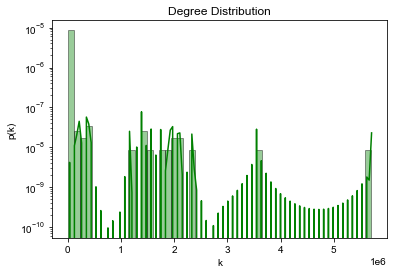

In [87]:
plot_degree_dist(merged)

#### VISUALIZATION 2

In this visualization we plot the input node and its neighborhood, and to show the importance we decide to plot the weight of the edges that link the input node to its neighbours nodes.

In [88]:
def vis2(G, node):
    
    section = [node] + list(G.neighbors(node))
    subset = G.subgraph(section)
    
    plt.rcParams["figure.figsize"] = (20,14)
    plt.title("Plot of the input node and the subset of its neighbours")
    
    pos=nx.spring_layout(subset)
    
    #plot the input node
    nx.draw_networkx_nodes(subset, pos, nodelist=[node], node_color='red', node_size=500)


    #plot the neighbors
    nx.draw_networkx_nodes(subset, pos, node_color='green', node_size=300)
    
    #plot edges
    labels = nx.get_edge_attributes(subset,'weight')
    nx.draw_networkx_edges(subset, pos, edge_color='cyan', connectionstyle=("Arc3, rad=0.3"))
    nx.draw_networkx_edge_labels(subset,edge_labels=labels, pos=pos, label_pos=0.5)
    
    
    plt.show()

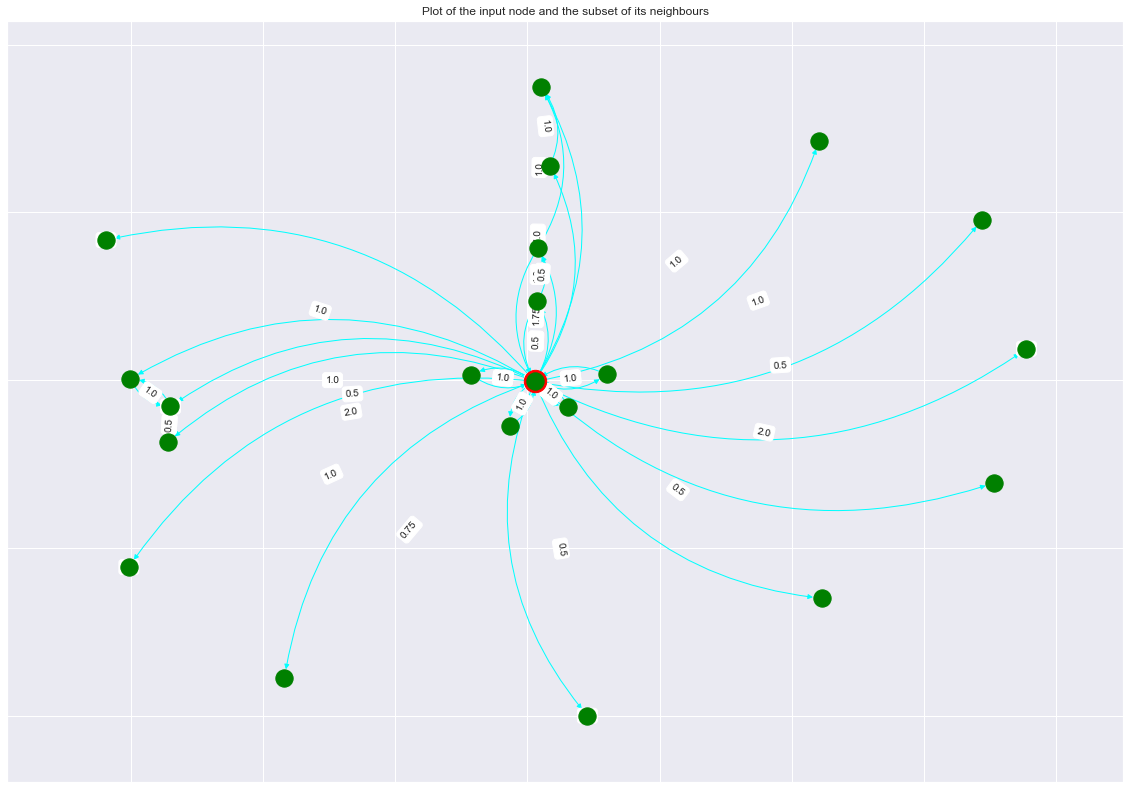

In [90]:

vis2(merged, '22656')

In [134]:
# Python3 code to Convert date range to N equal durations -- geeksforgeeks.com

  
def intervals(start_date, end_date, intv):
    
    # initializing dates
    first_date = dt.datetime.strptime(start_date, '%Y-%m-%d')
    second_date = dt.datetime.strptime(end_date, '%Y-%m-%d')
               
  
    # initializing N
    N = 10
  
    temp = []
  
    # getting diff.
    diff = ( second_date - first_date) // N
    for idx in range(0, N):
      
    # computing new dates
        temp.append((first_date + idx * diff))
  
    # using strftime to convert to userfriendly 
    # format
    res = []
    for sub in temp:
        res.append(sub.strftime("%Y-%m-%d "))
  
    # printing result
    print("N equal duration dates : " + str(res))

    return res + [end_date]

In [187]:
times = intervals('2008-11-01', '2008-11-10', 10)

N equal duration dates : ['2008-11-01 ', '2008-11-01 ', '2008-11-02 ', '2008-11-03 ', '2008-11-04 ', '2008-11-05 ', '2008-11-06 ', '2008-11-07 ', '2008-11-08 ', '2008-11-09 ']


In [184]:
def metric_time(node, time_intervals, metric):
    
    metric_over_time=[]
    
    for i in time_intervals:
        risultato=F2_BestUser(node, i, metric)
        metric_over_time.append(risultato)
    
    return metric_over_time

In [181]:
node='22656'
metric = 4
time_intervals = [("2008-11-01","2008-11-02" ), ('2008-11-02', '2008-11-03'),('2008-11-03','2008-11-04'), 
                  ('2008-11-04','2008-11-05'), ('2008-11-05','2008-11-06'), ('2008-11-06','2008-11-07'),
                 ('2008-11-07','2008-11-08'), ('2008-11-08','2008-11-09'), ('2008-11-09','2008-11-10')]

In [182]:
time = ["2008-11-01 to 2008-11-02", '2008-11-02 to 2008-11-03','2008-11-03 to 2008-11-04', 
       "2008-11-04'to 2008-11-05", '2008-11-05 to 2008-11-06', '2008-11-06 to 2008-11-07',
       '2008-11-07 to 2008-11-08', '2008-11-08 to 2008-11-09', '2008-11-09 to 2008-11-10']

In [185]:
metrics_list = metric_time(node, time_intervals, metric)
metrics_list

[0.0137, 0.0082, 0.0097, 0.0087, 0.0131, 0.0114, 0.0161, 0.0045, 0.0029]

Text(0, 0.5, 'Metric value')

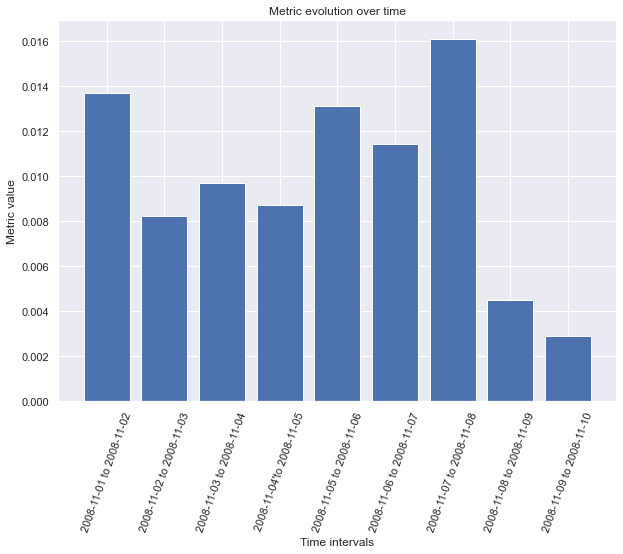

In [188]:
plt.figure(figsize=(10,7))
plt.bar(time, metrics_list)
plt.xticks(rotation=70)
plt.title('Metric evolution over time')
plt.xlabel('Time intervals')
plt.ylabel('Metric value')

#### VISUALIZATION 3

In [96]:
result_func3 = F3_ShortestRoute(("2014-01-01","2014-01-03"), ["780824", "576786", '577485'],
                                ("780824", '577485'))
result_func3

(5.25,
 ['780824',
  '3001356',
  '3021758',
  '2589776',
  '620029',
  '560648',
  '2963099',
  '576786'])

In [97]:
plt.rcParams["figure.figsize"]=(15,15)
def vis3(output):
    G = nx.DiGraph()

    for i in range(len(output)-1):
        G.add_edge(output[i],output[i+1], label=i)
        
    edge_labels = nx.get_edge_attributes(G, 'label')
    
    if not nx.is_empty(G):
        pos=nx.spring_layout(G)
        nx.draw(G,pos=pos, with_labels=True, font_size=20, connectionstyle=("Arc3, rad=0.3"))
        colors_node = ["blue"] + (["yellow"] * (len(output) - 1))
        nx.draw_networkx_nodes(G,pos, node_size = 600, node_color=colors_node)
        
        
        
            
        plt.show()

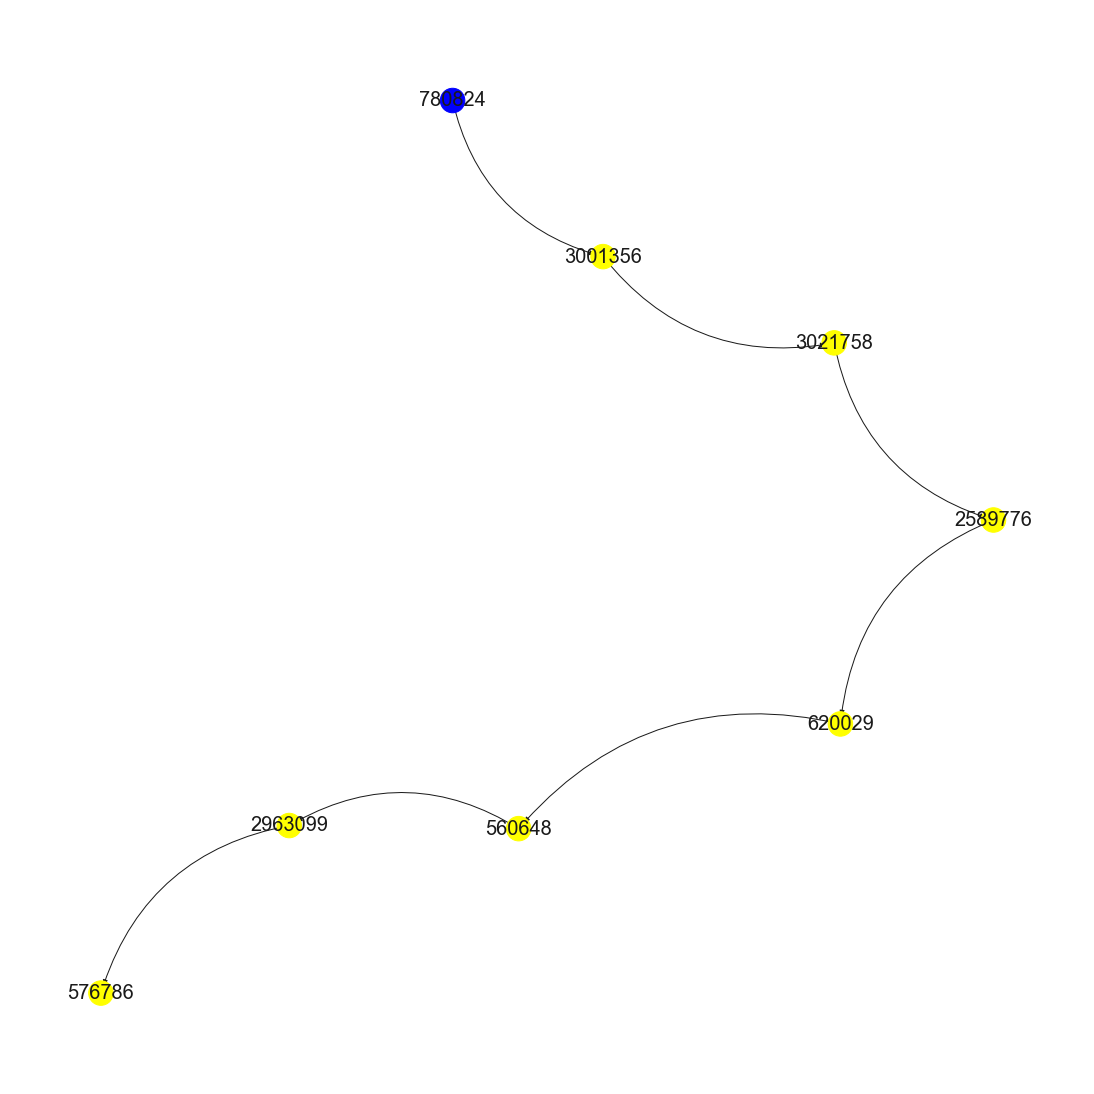

In [98]:
vis3(result_func3[1])

#### VISUALIZATION 4

In [261]:
def vis4_inizio(gX,gY,start_node, end_node, node_disconnect):
    
    #output_F4 = F4_DisconnectingGraphs(("2008-11-01 00:00","2008-11-02 00:00"), 
                                    # ("2008-11-02 00:00","2008-11-03 00:00"))
    
     
    f, axs = plt.subplots(2,1,figsize=(15,15))
    
    nx.draw(gX,ax=axs[0], with_labels=True, edge_color='orange', node_color='orange', node_size=300)
    
    
    
    nx.draw(gY,ax=axs[1], with_labels=True, edge_color='green', node_color='green', node_size=300)
    plt.title("Network gX and  gy")
    
    plt.show()

In [255]:
def vis4_final(gX, gY, node_disconnect):
    plt.rcParams["figure.figsize"] = (20,12)
    plt.title("The red node is the one whose links have to be deleted to disconnect graphs")
    graph=nx.compose(gX,gY)
    pos = nx.spring_layout(graph) 
   
   
    nx.draw(graph, with_labels=True, pos=pos, edge_color='grey', node_color='blue')
    nx.draw_networkx(graph.subgraph([node_disconnect]), pos=pos, node_size=800, node_color='red', font_color='green')
    

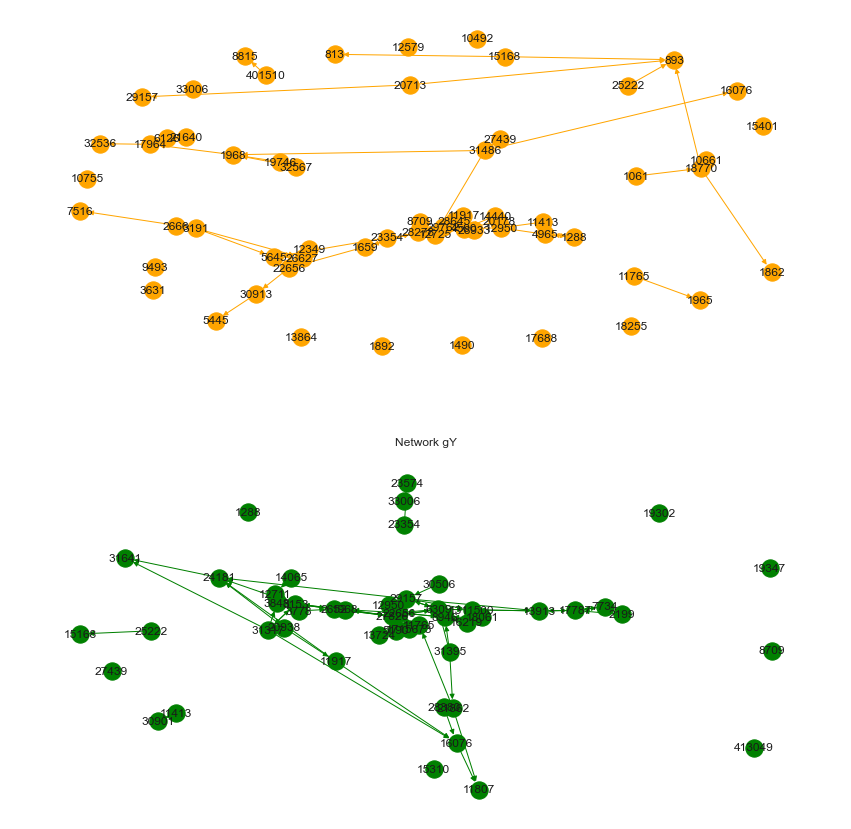

In [262]:
vis4_inizio(gX=output_F4[4],gY=output_F4[5], start_node=output_F4[2], end_node=output_F4[3], 
         node_disconnect=output_F4[1])

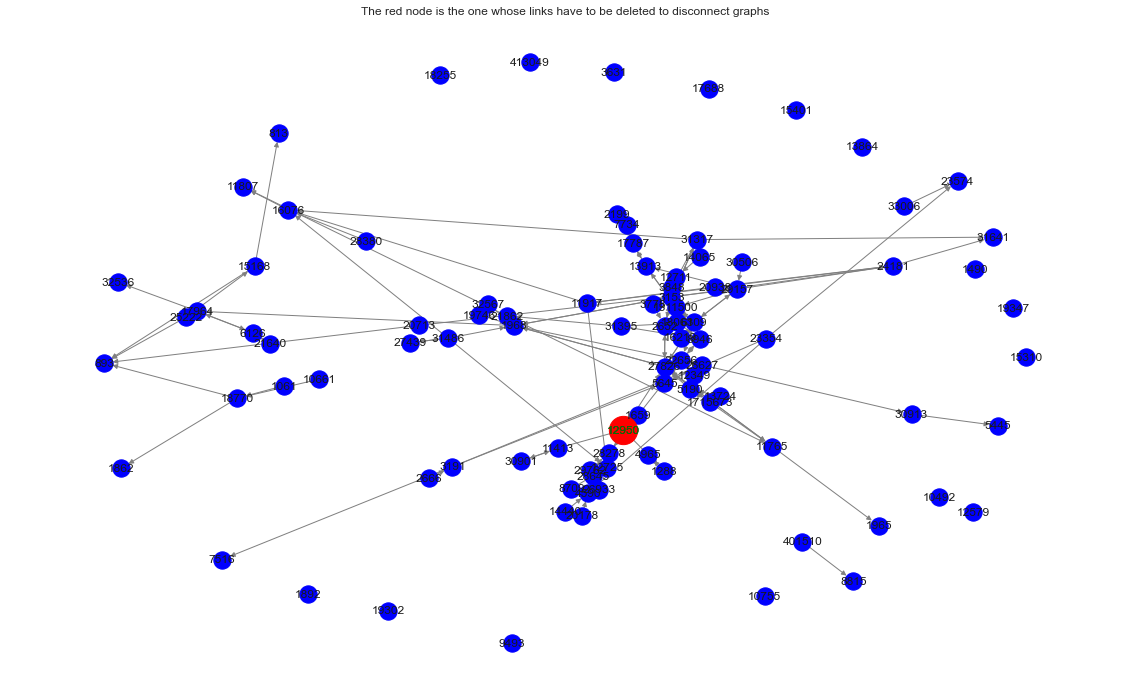

In [257]:
vis4_final(gX=output_F4[4],gY=output_F4[5], node_disconnect=output_F4[1])

## 4. Algorithmic question

For performance reason, I decided to build a dictionary with as keys the kids and as values the enemies of a specific kid. We can assume that the data is given in this format, so we don't calculate the time complexity for building this data structure.

I will show anyway the code where I build this dictionary, starting from two lists.

In [131]:
kids = [1,2,3,4,5,6,7,8,9,10]
pairs = [(1,2), (3,4), (7,8), (5,7), (2,10), (8,9)]

In [132]:
# Dictionary with keys the kids and as values the list of enemies kids
fight_dict = { kid:[] for kid in kids}

In [133]:
fight_dict

{1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}

In [134]:
# Fill the dictionary
for pair in pairs:
    if pair[1] not in fight_dict[pair[0]]:
        fight_dict[pair[0]].append(pair[1])
    if pair[0] not in fight_dict[pair[1]]:
        fight_dict[pair[1]].append(pair[0])

In [2]:
fight_dict

NameError: name 'fight_dict' is not defined

The algorithm will explore the dictionary, each time looking in the same time to the enemies and the dormitories and then decide in which put the kid.

The algorithm will return **two empty lists** if there is not possible to have a solution.

In [136]:
def fill_dormitories(fights):
    
    # Create the two dormitories lists
    d1 = []
    d2 = []
    
    # Iterating through the dictionary created
    for kid, enemies in fights.items():
        # If there is at least one enemy of the kid present in both dormitories --> return two empty lists becouse we can't compleate the dormitories
        if any(enemy in d1  for enemy in enemies) and any(enemy in d2  for enemy in enemies):
            return [], []
        # If there is an enemy only in the dormitory d2
        elif any(enemy in d2  for enemy in enemies):
            d1.append(kid)
        # Otherwise i put him in d2
        else:
            d2.append(kid)
            
    return d1, d2

In [137]:
dormitory_1, dormitory_2 = fill_dormitories(fight_dict)

In [138]:
print("Dormitory 1 is ", dormitory_1)
print("Dormitory 2 is ", dormitory_2)

Dormitory 1 is  [2, 4, 7, 9]
Dormitory 2 is  [1, 3, 5, 6, 8, 10]


#### Analysis of the algorithm

The complexity of the algorithm is $O(n*k)$, where $n$ is the number of kids and $k$ is the number of pairs.

The algorithm iterates through a dictionary, so it takes $O(n)$. 

After that, for each iteration it checks all the values (enemies) in the dictionary and it will takes $O(k)$.